# internal Dataset - ANALYSES (Hypothesis 3a)

## context
This internal dataset is one individual's (Nono's) training data over 7 years of training for Triathlon including 4 injuries.

## aim
We want to see, if we can also verify the Hypothesis 3a ("There is a significant change in training before an injury").

As Nono's injury mostly were related to running, we mainly focus on that part of the training. Nevertheless we build an aggregated column with relative distance, because 1km swimming is different then 1km cycling or running.  

## process
1. preparing 
    bringing the data in the same aggregated condition as the injury-datasets.
    - fill up all days 
    - drop columns & build new columns for
        - Injury
        - mileage (RunDistance in km)
        - Sessions
        - Rest Days
        - relative distance (RelTriDistance: weighting depending on ratio during short&middle distance Triathlon)

    - build structure of 3-weeks-perspective from every daypoint with .rolling
        - w1_
        - w2_
        - w3_
2. Analyses
    - distribution: Shapiro-Wilk-Test
    - significance: 
        - T-Test (due to normal distribution)  
        - Mann-Whitnyey-U-Test (due to Imbalance of sample size of the two groups)
        - Permutation Test
        - boxplot

## result
Unlike in the comparative data set, the data here is often normally distributed.

As the two groups (injury = 1 vs injury =0) we had to try several testing procedures and after comparing them we come to the result that we have significant differences before an injury on the following features:
- significance on all three tests:
    - w3_RunKm (✅ all)
    - w3_RelTriDistance (✅ all )

- significance on two test
    - w4_RunKm (✅ T-Test, Mann-Whitney U-Test)
    - m_RunKm (✅ Mann-Whitney U-Test, Permutation Test)
    - w3_Sessions (✅ Mann-Whitney U-Test, Permutation Test)

- significance on one test
    - w1_KmZ5 (✅ T-Test)
    - w3_KmZ5 (✅ T-Test)
    - w1_RestDays (✅ T-Test)
    - w2_KmZ5 (✅ Mann-Whitney U-Test)

## further steps
Compare if in the Open Source Dataset there are differences between athletes, too

---------------------------------------

In [4]:
## import relevant packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import io
from scipy import stats
from scipy.stats import shapiro

import warnings
warnings.filterwarnings("ignore")

# _reading data

### SQAlchemy

In [1]:
from sqlalchemy import create_engine, types
from sqlalchemy import text # to be able to pass string
from sqlalchemy.exc import SQLAlchemyError
from dotenv import dotenv_values # to load the data from .env file

preparing the connection

In [2]:
#load the data from .env file
config = dotenv_values()

# define variables for the login
pg_user = config['AZURE_USER'] 
pg_host = config['AZURE_HOST']
pg_port = config['AZURE_PORT']
pg_db = config['AZURE_DB']
pg_schema = config['AZURE_SCHEMA']
pg_pass = config['AZURE_PASS']

# build the URL
url = f'postgresql://{pg_user}:{pg_pass}@{pg_host}:{pg_port}/{pg_db}'

# create the engine
engine = create_engine(url, echo=False)
engine.url

# build the search path
my_schema = pg_schema 
with engine.begin() as conn: 
    result = conn.execute(text(f'SET search_path TO {my_schema};'))

testing the connection

In [3]:
def test_db_connection(engine):
    try:
        connection = engine.connect() # including 'connection' as variable to close the connection
        print("Connection successful!")
        connection.close() # closing the connection
        return True
    except SQLAlchemyError as e:
        print(f"Connection failed: {e}")
        return False

# Test the connection
test_db_connection(engine)

Connection successful!


True

reading DataFrames FROM Database

In [5]:
df_train_raw = pd.read_sql(sql=text('SELECT * FROM public.df_activs_plus;'), con=engine)

df_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 85 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   activity id            1038 non-null   int64  
 1   date                   1038 non-null   object 
 2   activity date          1038 non-null   object 
 3   sport                  1038 non-null   object 
 4   activity type          1038 non-null   object 
 5   start time             1038 non-null   object 
 6   moving time            1038 non-null   object 
 7   elapsed time           945 non-null    object 
 8   finish time            945 non-null    object 
 9   swim pace              240 non-null    object 
 10  bike pace              413 non-null    object 
 11  run pace               379 non-null    object 
 12  distance               1035 non-null   float64
 13  avg heart rate         685 non-null    float64
 14  avg heart rate zone    1038 non-null   object 
 15  max 

# 1. preparing

## 1.1 fill up dates

For having a similar dataset we need all days of the period in it and count the days without training as Rest Days.

In [6]:
# date als datetime

df_train_raw['date'] = pd.to_datetime(df_train_raw['date'])

In [7]:
## fill up with empty date rows (for restdays)

# build a date series
full_dates = pd.date_range(start=df_train_raw['date'].min(), end=df_train_raw['date'].max(), freq='D')

# new dataset with all dates in it
df_full = pd.DataFrame({'date': full_dates})

# Merge left join on complete data serie
df_full_date = df_full.merge(df_train_raw, on='date', how='left')

df_full_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2470 entries, 0 to 2469
Data columns (total 85 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   2470 non-null   datetime64[ns]
 1   activity id            1038 non-null   float64       
 2   activity date          1038 non-null   object        
 3   sport                  1038 non-null   object        
 4   activity type          1038 non-null   object        
 5   start time             1038 non-null   object        
 6   moving time            1038 non-null   object        
 7   elapsed time           945 non-null    object        
 8   finish time            945 non-null    object        
 9   swim pace              240 non-null    object        
 10  bike pace              413 non-null    object        
 11  run pace               379 non-null    object        
 12  distance               1035 non-null   float64       
 13  avg

Like this there are many cells without entries. Filling them up with '0' as there is f.e. no mileage on a rest day.

In [8]:
# fill up with 0

df_full_date.fillna(0, inplace=True)

## 1.2 drop columns

Not all columns are necessary for this analysis. 

In [9]:
# list of columns

list(df_full_date.columns)

['date',
 'activity id',
 'activity date',
 'sport',
 'activity type',
 'start time',
 'moving time',
 'elapsed time',
 'finish time',
 'swim pace',
 'bike pace',
 'run pace',
 'distance',
 'avg heart rate',
 'avg heart rate zone',
 'max heart rate',
 'max heart rate yearly',
 'avg speed',
 'max speed',
 'avg elapsed speed',
 'relative effort',
 'calories',
 'pool length',
 'elevation gain',
 'elevation loss',
 'elevation low',
 'elevation high',
 'max grade',
 'avg grade',
 'avg watts',
 'avg cadence',
 'max cadence',
 'activity name',
 'activity description',
 'perceived exertion',
 'event',
 'injury description',
 'filename',
 'filenumber',
 'below zones',
 'no hr collected',
 'z1',
 'z2',
 'z3',
 'z4',
 'z5',
 'time low zones',
 'time high zones',
 'training mode',
 'dist below zones',
 'dist no hr collected',
 'dist z1',
 'dist z2',
 'dist z3',
 'dist z4',
 'dist z5',
 'cycle id',
 'wake onset',
 'to bed date',
 'sleep onset',
 'sleep performance',
 'recovery score',
 'day strain'

In [10]:
df_full_date = df_full_date.drop(axis=1, columns=
                  [  
'event', 
'injury description', 
 'activity type',
 'start time',
 'moving time',
 'elapsed time',
 'finish time',
 'swim pace',
 'bike pace',
 'run pace',
 'avg heart rate',
 'avg heart rate zone',
 'max heart rate',
 'max heart rate yearly',
 'avg speed',
 'max speed',
 'avg elapsed speed',
 'relative effort',
 'calories',
 'pool length',
 'elevation gain',
 'elevation loss',
 'elevation low',
 'elevation high',
 'max grade',
 'avg grade',
 'avg watts',
 'avg cadence',
 'max cadence',
 'activity name',
 'activity description',
 'perceived exertion',
 'filename',
 'filenumber',
 'below zones',
 'no hr collected',
 'z1',
 'z2',
 'z3',
 'z4',
 'z5',
 'time low zones',
 'time high zones',
 'training mode',
 'cycle id',
 'wake onset',
 'to bed date',
 'sleep onset',
 'sleep performance',
 'recovery score',
 'day strain',
 'rhr',
 'hrv',
 'respiratory rate',
 'asleep duration',
 'in bed duration',
 'light sleep duration',
 'deep sleep duration',
 'rem sleep duration',
 'awake duration',
 'sleep need',
 'sleep debt',
 'sleep efficiency',
 'sleep consistency',
 'skin temp',
 'blood oxygen',
 'cal burned',
 'max hr',
 'avg hr',
 'cycle start time',
 'cycle end time',
 'cycle timezone'])

In [11]:
df_full_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2470 entries, 0 to 2469
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  2470 non-null   datetime64[ns]
 1   activity id           2470 non-null   float64       
 2   activity date         2470 non-null   object        
 3   sport                 2470 non-null   object        
 4   distance              2470 non-null   float64       
 5   dist below zones      2470 non-null   float64       
 6   dist no hr collected  2470 non-null   float64       
 7   dist z1               2470 non-null   float64       
 8   dist z2               2470 non-null   float64       
 9   dist z3               2470 non-null   float64       
 10  dist z4               2470 non-null   float64       
 11  dist z5               2470 non-null   float64       
 12  moving time seconds   2470 non-null   float64       
dtypes: datetime64[ns](

## 1.3 new columns

### 1.3.1 Injury

There are 4 dates with an injury.

In [12]:
## create column 'Injury' and fill with the 4 events.

# list of the four injuries
injury_dates = ['2021-06-30', '2021-08-08', '2024-02-11', '2024-10-10']

# default: injury = 0
df_full_date['Injury'] = 0

# change injury = 1 for the listed dates
df_full_date.loc[df_full_date['date'].isin(pd.to_datetime(injury_dates)), 'Injury'] = 1

### 1.3.2 mileage in km by discipline

The column 'sport' defines the discipline. With a combination of the information of the discipline and the distance we build new columns. 
- SwimDistance
- BikeDistance
- RunDistance

In [36]:
## building new structured dataframe with distances and only relevant rows

# group by 'date' and 'sport' und sum 'distance' = for every discipline a row with the distance
# for the days without sport (sport =0) there will be a new column 0 that I drop after
df_sport = df_full_date.groupby(['date', 'sport'])['distance'].sum().unstack(fill_value=0)

# rename to the new column names
df_sport = df_sport.rename(columns={'Run': 'RunDistance', 'Bike': 'BikeDistance', 'Swim': 'SwimDistance'})

# round all distance columns to one decimal place
df_sport = df_sport.round(1)

# select other columns that we want to keep
df_other = df_full_date[['date', 'Injury', 'dist z5']].drop_duplicates(subset=['date'])

# bring together to a new dataframe
df_final = df_other.merge(df_sport, on='date', how='left')

# drop the '0' column if it exists
df_final = df_final.drop(columns=[0], errors='ignore')

df_final.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2309 entries, 0 to 2308
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          2309 non-null   datetime64[ns]
 1   Injury        2309 non-null   int64         
 2   dist z5       2309 non-null   float64       
 3   BikeDistance  2309 non-null   float64       
 4   RunDistance   2309 non-null   float64       
 5   SwimDistance  2309 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 108.4 KB


### 1.3.3 Sessions 


Depending on the distance of each discipline counting the number of Sessions

In [37]:
# new column 'Session' counts how many Distance columns are > 0 (0 bis 3)
df_final['Sessions'] = (df_final[['RunDistance', 'SwimDistance', 'BikeDistance']] > 0).sum(axis=1)

# count occurence
session_counts = df_final['Sessions'].value_counts().sort_index()

# print result (incl grammar change)
output = "\n".join([
    f"{count} days with {session} activity" if session == 1 else f"{count} days with {session} activities"
    for session, count in session_counts.items()
])
print("-" * 30)
print(f"There are:\n{output}")
print("-" * 30)

------------------------------
There are:
1436 days with 0 activities
778 days with 1 activity
69 days with 2 activities
26 days with 3 activities
------------------------------


### 1.3.4 Rest Days

aggregated out of Sessions

In [38]:
# 'RestDay' ist genau das Gegenteil: 1, wenn keine Session stattfand, sonst 0
df_final['RestDay'] = (df_final['Sessions'] == 0).astype(int)

df_final.head()


,date,Injury,dist z5,BikeDistance,RunDistance,SwimDistance,Sessions,RestDay
0,2018-10-18,0,0.0,13.5,0.0,1.5,2,0
1,2018-10-19,0,0.0,0.0,0.0,0.0,0,1
2,2018-10-20,0,0.0,0.0,0.0,0.0,0,1
3,2018-10-21,0,0.0,0.0,5.1,0.0,1,0
4,2018-10-22,0,0.0,22.5,0.0,0.0,1,0


### 1.3.5 relative distance (Traithlon ratio)

As Nono is not only running but he is training for Triathlon the other two disciplines (swimming and cycling) may be interesting, too.
But as 1km in swimming is harder then 1km running or biking, we give those discipline_distances a weight following the Triathlon ratio for sprint and olympic distances, which is swim : bike : run = 1:26.7:6.7

The calculation of the total RelTriDistance is based on this weighting.

In [39]:
# weighting by Triathlon ratio
swim_weight = 1
bike_weight = 26.7
run_weight = 6.7

# calculate by division
df_final['RelTriDistance'] = (
    df_final['SwimDistance'] / swim_weight +
    df_final['BikeDistance'] / bike_weight +
    df_final['RunDistance'] / run_weight
)

df_final[['SwimDistance', 'BikeDistance', 'RunDistance', 'RelTriDistance']].head()


,SwimDistance,BikeDistance,RunDistance,RelTriDistance
0,1.5,13.5,0.0,2.005618
1,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.000000
3,0.0,0.0,5.1,0.761194
4,0.0,22.5,0.0,0.842697


## 1.4 aggregate 3-weeks-periodes

By using .rolling I group rows to 7-days-periods as one week before, two weeks before, three weeks before an injury (or a normal event).

### 1.4.1 Run Distance

for running I also do 4 weeks before and the month in total because during analyses we didn't get significant differences

In [44]:
## buidling the total Run Distance in km by weeks

# calculate the 7-day-sum for each week
df_final['w1_RunKm'] = df_final['RunDistance'].shift(1).rolling(window=7, min_periods=1).sum()
df_final['w2_RunKm'] = df_final['RunDistance'].shift(8).rolling(window=7, min_periods=1).sum()
df_final['w3_RunKm'] = df_final['RunDistance'].shift(15).rolling(window=7, min_periods=1).sum()
df_final['w4_RunKm'] = df_final['RunDistance'].shift(22).rolling(window=7, min_periods=1).sum()
df_final['m_RunKm'] = df_final['RunDistance'].shift(1).rolling(window=30, min_periods=1).sum()

# calculate the variance
df_final['VaRunVolumeChange_w'] = df_final[['w3_RunKm', 'w2_RunKm', 'w1_RunKm', 'w4_RunKm']].var(axis=1)

# calculate trend
df_final['TrendRunVolumeChange_w'] = df_final["w1_RunKm"] - df_final["w4_RunKm"]

# show result
print(df_final[['w1_RunKm', 'w2_RunKm', 'w3_RunKm', 'w4_RunKm', 'm_RunKm', 'VaRunVolumeChange_w', 'TrendRunVolumeChange_w']].tail(10))

      w1_RunKm  w2_RunKm  w3_RunKm  w4_RunKm  m_RunKm  VaRunVolumeChange_w  \
2299       0.0       0.0       0.0       0.0      0.0                  0.0   
2300       0.0       0.0       0.0       0.0      0.0                  0.0   
2301       0.0       0.0       0.0       0.0      0.0                  0.0   
2302       0.0       0.0       0.0       0.0      0.0                  0.0   
2303       0.0       0.0       0.0       0.0      0.0                  0.0   
2304       0.0       0.0       0.0       0.0      0.0                  0.0   
2305       0.0       0.0       0.0       0.0      0.0                  0.0   
2306       0.0       0.0       0.0       0.0      0.0                  0.0   
2307       0.0       0.0       0.0       0.0      0.0                  0.0   
2308       0.0       0.0       0.0       0.0      0.0                  0.0   

      TrendRunVolumeChange_w  
2299                     0.0  
2300                     0.0  
2301                     0.0  
2302             

### 1.4.2 High intensity as KmZ5

In [45]:
## buidling the Km in Heartrate Zone 5 by weeks

# calculate the 7-day-sum for each week
df_final['w1_KmZ5'] = df_final['dist z5'].shift(1).rolling(window=7, min_periods=1).sum()
df_final['w2_KmZ5'] = df_final['dist z5'].shift(8).rolling(window=7, min_periods=1).sum()
df_final['w3_KmZ5'] = df_final['dist z5'].shift(15).rolling(window=7, min_periods=1).sum()

# calculate the variance
df_final['VarKmZ5_w'] = df_final[['w3_KmZ5', 'w2_KmZ5', 'w1_KmZ5']].var(axis=1)

# calculate trend
df_final['TrendKmZ5_w'] = df_final["w1_KmZ5"] - df_final["w3_KmZ5"]

# show result
print(df_final[['w3_KmZ5', 'w2_KmZ5', 'w1_KmZ5', 'VarKmZ5_w', 'TrendKmZ5_w']].tail(10))

      w3_KmZ5  w2_KmZ5  w1_KmZ5  VarKmZ5_w  TrendKmZ5_w
2299      0.0      0.0      0.0        0.0          0.0
2300      0.0      0.0      0.0        0.0          0.0
2301      0.0      0.0      0.0        0.0          0.0
2302      0.0      0.0      0.0        0.0          0.0
2303      0.0      0.0      0.0        0.0          0.0
2304      0.0      0.0      0.0        0.0          0.0
2305      0.0      0.0      0.0        0.0          0.0
2306      0.0      0.0      0.0        0.0          0.0
2307      0.0      0.0      0.0        0.0          0.0
2308      0.0      0.0      0.0        0.0          0.0


### 1.4.3 Sessions 

In [46]:
## buidling the number of sessions by weeks

# calculate the 7-day-sum for each week
df_final['w1_Sessions'] = df_final['Sessions'].shift(1).rolling(window=7, min_periods=1).sum()
df_final['w2_Sessions'] = df_final['Sessions'].shift(8).rolling(window=7, min_periods=1).sum()
df_final['w3_Sessions'] = df_final['Sessions'].shift(15).rolling(window=7, min_periods=1).sum()

# calculate the variance
df_final['VarSessions_w'] = df_final[['w3_Sessions', 'w2_Sessions', 'w1_Sessions']].var(axis=1)

# calculate trend
df_final['TrendSessions_w'] = df_final["w1_Sessions"] - df_final["w3_Sessions"]

# show result
print(df_final[['w3_Sessions', 'w2_Sessions', 'w3_Sessions', 'VarSessions_w', 'TrendSessions_w']].tail(10))


      w3_Sessions  w2_Sessions  w3_Sessions  VarSessions_w  TrendSessions_w
2299          3.0          3.0          3.0       0.000000              0.0
2300          2.0          3.0          2.0       0.333333              1.0
2301          3.0          3.0          3.0       0.333333             -1.0
2302          2.0          3.0          2.0       0.333333              1.0
2303          2.0          3.0          2.0       0.333333              0.0
2304          2.0          3.0          2.0       0.333333              0.0
2305          2.0          3.0          2.0       0.333333              1.0
2306          3.0          3.0          3.0       0.333333             -1.0
2307          3.0          3.0          3.0       0.333333             -1.0
2308          3.0          2.0          3.0       0.333333             -1.0


### 1.4.4 Rest Days

In [47]:
## buidling the number of RestDays by weeks

# calculate the 7-day-sum for each week
df_final['w1_RestDays'] = df_final['RestDay'].shift(1).rolling(window=7, min_periods=1).sum()
df_final['w2_RestDays'] = df_final['RestDay'].shift(8).rolling(window=7, min_periods=1).sum()
df_final['w3_RestDays'] = df_final['RestDay'].shift(15).rolling(window=7, min_periods=1).sum()

# calculate the variance
df_final['VarRestDays_w'] = df_final[['w3_RestDays', 'w2_RestDays', 'w1_RestDays']].var(axis=1)

# calculate trend
df_final['TrendRestDays_w'] = df_final["w1_RestDays"] - df_final["w3_RestDays"]

# show result
print(df_final[['w3_RestDays', 'w2_RestDays', 'w1_RestDays', 'VarRestDays_w', 'TrendRestDays_w']].tail(10))

      w3_RestDays  w2_RestDays  w1_RestDays  VarRestDays_w  TrendRestDays_w
2299          4.0          4.0          4.0       0.000000              0.0
2300          5.0          4.0          4.0       0.333333             -1.0
2301          4.0          4.0          5.0       0.333333              1.0
2302          5.0          4.0          4.0       0.333333             -1.0
2303          5.0          4.0          5.0       0.333333              0.0
2304          5.0          4.0          5.0       0.333333              0.0
2305          5.0          4.0          4.0       0.333333             -1.0
2306          4.0          4.0          5.0       0.333333              1.0
2307          4.0          4.0          5.0       0.333333              1.0
2308          4.0          5.0          5.0       0.333333              1.0


### 1.4.5 RelTriDistance

In [48]:
## buidling the relative total distance

# calculate the 7-day-sum for each week
df_final['w1_RelTriDistance'] = df_final['RelTriDistance'].shift(1).rolling(window=7, min_periods=1).sum()
df_final['w2_RelTriDistance'] = df_final['RelTriDistance'].shift(8).rolling(window=7, min_periods=1).sum()
df_final['w3_RelTriDistance'] = df_final['RelTriDistance'].shift(15).rolling(window=7, min_periods=1).sum()

# calculate the variance
df_final['VarRelTriDistance_w'] = df_final[['w3_RelTriDistance', 'w2_RelTriDistance', 'w1_RelTriDistance']].var(axis=1)

# calculate trend
df_final['TrendRelTriDistance_w'] = df_final["w1_RelTriDistance"] - df_final["w3_RelTriDistance"]

# show result
print(df_final[['w3_RelTriDistance', 'w2_RelTriDistance', 'w1_RelTriDistance', 'VarRelTriDistance_w', 'TrendRelTriDistance_w']].tail(10))

      w3_RelTriDistance  w2_RelTriDistance  w1_RelTriDistance  \
2299           7.105618               10.2                9.4   
2300           4.305618               10.2                9.4   
2301           7.905618               10.2                5.8   
2302           7.400000               10.2                9.8   
2303           7.400000                9.5                6.7   
2304           7.400000                9.5                6.7   
2305           7.400000                9.5                9.5   
2306          10.200000                9.4                6.8   
2307          10.200000                9.4                6.8   
2308          10.200000                5.8                6.8   

      VarRelTriDistance_w  TrendRelTriDistance_w  
2299             2.579898               2.294382  
2300            10.222745               5.094382  
2301             4.842969              -2.105618  
2302             2.293333               2.400000  
2303             2.123333    

# 2. Analyses

We follow now the Analyses we used on the Open Source Injury Dataset. First testing for distribution and then for significant differences compairing the two groups injury=0 and injury=1. The second group (pre-injury-week) only has 4 entries. We will see if that poses problems.

In [71]:
# preparing the features to be tested  

w_Features = [
              'w1_RunKm', 
              'w2_RunKm', 
              'w3_RunKm', 
              'w4_RunKm', 
              'm_RunKm',
              #'VaRunVolumeChange_w', 
              #'TrendRunVolumeChange_w',

              'w1_KmZ5', 
              'w2_KmZ5',
              'w3_KmZ5',
              #'VarKmZ5_w',
              #'TrendKmZ5_w',
                
              'w1_Sessions', 
              'w2_Sessions', 
              'w3_Sessions',
              #'VarSessions_w',
              #'TrendSessions_w',

              'w1_RestDays',
              'w2_RestDays',
              'w3_RestDays',
              #'VarRestDays_w', 
              #'TrendRestDays_w',

              'w3_RelTriDistance', 
              'w2_RelTriDistance', 
              'w1_RelTriDistance', 
              #'VarRelTriDistance_w', 
              #'TrendRelTriDistance_w'
              ]

### 2.1 distribution: Shapiro-Wilk-Test

In [65]:
# distribution test

print("🔬 testing normal distribution (Shapiro-Wilk-Test):\n")
for day in w_Features:
    stat, p_value = shapiro(df_final[w_Features])
    if p_value < 0.05:
        result = "❌ NO normal distribution"
    else:
        result = "✅ normal distribution"
    
    print(f"{day}: W={stat:.3f}, p={p_value:.5f} → {result}")

🔬 testing normal distribution (Shapiro-Wilk-Test):

w1_RunKm: W=nan, p=1.00000 → ✅ normal distribution
w2_RunKm: W=nan, p=1.00000 → ✅ normal distribution
w3_RunKm: W=nan, p=1.00000 → ✅ normal distribution
w4_RunKm: W=nan, p=1.00000 → ✅ normal distribution
m_RunKm: W=nan, p=1.00000 → ✅ normal distribution
VaRunVolumeChange_w: W=nan, p=1.00000 → ✅ normal distribution
TrendRunVolumeChange_w: W=nan, p=1.00000 → ✅ normal distribution
w1_KmZ5: W=nan, p=1.00000 → ✅ normal distribution
w2_KmZ5: W=nan, p=1.00000 → ✅ normal distribution
w3_KmZ5: W=nan, p=1.00000 → ✅ normal distribution
VarKmZ5_w: W=nan, p=1.00000 → ✅ normal distribution
TrendKmZ5_w: W=nan, p=1.00000 → ✅ normal distribution
w1_Sessions: W=nan, p=1.00000 → ✅ normal distribution
w2_Sessions: W=nan, p=1.00000 → ✅ normal distribution
w3_Sessions: W=nan, p=1.00000 → ✅ normal distribution
VarSessions_w: W=nan, p=1.00000 → ✅ normal distribution
TrendSessions_w: W=nan, p=1.00000 → ✅ normal distribution
w1_RestDays: W=nan, p=1.00000 → ✅ n

Unlike in the comparative data set, the data here is often normally distributed.

So for the significance we can use the T-Test.

## 2.2 T-Test for significance

In [66]:
print("🔬 T-Test (for normal distributed valuest):\n")   

# preparing two seperate injury-groups for compairing if any signifcant difference
for feature in w_Features:
    df_injury_0 = df_final[df_final["Injury"] == 0][feature]
    df_injury_1 = df_final[df_final["Injury"] == 1][feature]

# using t test for compairing 
    t_stat, p_value = stats.ttest_ind(df_injury_0, df_injury_1, equal_var=False, nan_policy='omit')

    # Ergebnis anzeigen mit Symbolen für klare Interpretation
    if p_value < 0.05:
        print(f"'{feature}' - ✅ significantly different (p-value: {p_value:.4f})")
    else:
        print(f"'{feature}' - ❌ NO significant difference (p-value: {p_value:.4f})")

🔬 T-Test (for normal distributed valuest):

'w1_RunKm' - ❌ NO significant difference (p-value: 0.2757)
'w2_RunKm' - ❌ NO significant difference (p-value: 0.2674)
'w3_RunKm' - ✅ significantly different (p-value: 0.0316)
'w4_RunKm' - ✅ significantly different (p-value: 0.0024)
'm_RunKm' - ❌ NO significant difference (p-value: 0.0898)
'VaRunVolumeChange_w' - ❌ NO significant difference (p-value: 0.2439)
'TrendRunVolumeChange_w' - ❌ NO significant difference (p-value: 0.7418)
'w1_KmZ5' - ✅ significantly different (p-value: 0.0000)
'w2_KmZ5' - ❌ NO significant difference (p-value: 0.4613)
'w3_KmZ5' - ✅ significantly different (p-value: 0.0000)
'VarKmZ5_w' - ✅ significantly different (p-value: 0.0012)
'TrendKmZ5_w' - ❌ NO significant difference (p-value: 1.0000)
'w1_Sessions' - ❌ NO significant difference (p-value: 0.1036)
'w2_Sessions' - ❌ NO significant difference (p-value: 0.7492)
'w3_Sessions' - ❌ NO significant difference (p-value: 0.1541)
'VarSessions_w' - ❌ NO significant difference (

As the size of the two groups is very different, we also apply the Mann-Whitney-U-Test.

## 2.3. Mann-Whitney-U-test for significance (small injury group)

In [67]:
print("🔬 Mann-Whitney-U-Test (non-parametric Test):\n")

# preparing two separate injury groups for comparing if any significant difference - 
# dropna() because at the beginning of the time periode there won't be enough data for rolling over 21 days
for feature in w_Features:
    df_injury_0 = df_final[df_final["Injury"] == 0][feature].dropna()
    df_injury_1 = df_final[df_final["Injury"] == 1][feature].dropna()

    # using Mann-Whitney-U test for comparing
    u_stat, p_value = stats.mannwhitneyu(df_injury_0, df_injury_1, alternative='two-sided')

    # Ergebnis anzeigen mit Symbolen für klare Interpretation
    if p_value < 0.05:
        print(f"'{feature}' - ✅ significantly different (p-value: {p_value:.4f})")
    else:
        print(f"'{feature}' - ❌ NO significant difference (p-value: {p_value:.4f})")

🔬 Mann-Whitney-U-Test (non-parametric Test):

'w1_RunKm' - ❌ NO significant difference (p-value: 0.1070)
'w2_RunKm' - ❌ NO significant difference (p-value: 0.1429)
'w3_RunKm' - ✅ significantly different (p-value: 0.0065)
'w4_RunKm' - ✅ significantly different (p-value: 0.0315)
'm_RunKm' - ✅ significantly different (p-value: 0.0144)
'VaRunVolumeChange_w' - ❌ NO significant difference (p-value: 0.0681)
'TrendRunVolumeChange_w' - ❌ NO significant difference (p-value: 0.9165)
'w1_KmZ5' - ❌ NO significant difference (p-value: 0.5909)
'w2_KmZ5' - ✅ significantly different (p-value: 0.0010)
'w3_KmZ5' - ❌ NO significant difference (p-value: 0.5897)
'VarKmZ5_w' - ❌ NO significant difference (p-value: 0.1347)
'TrendKmZ5_w' - ❌ NO significant difference (p-value: 0.9713)
'w1_Sessions' - ❌ NO significant difference (p-value: 0.0949)
'w2_Sessions' - ❌ NO significant difference (p-value: 0.8124)
'w3_Sessions' - ✅ significantly different (p-value: 0.0479)
'VarSessions_w' - ❌ NO significant difference

## 2.4 Permutation test + comparing

In [78]:
# Iterate through the features and run all tests
for feature in w_Features:
    if feature in df_final.columns:  # Check if the feature exists in the dataframe
        # Extract data for injury groups, ignoring NaNs
        df_injury_0 = df_final[df_final["Injury"] == 0][feature].dropna()
        df_injury_1 = df_final[df_final["Injury"] == 1][feature].dropna()

        # Welch T-Test (unequal variance)
        t_stat, p_value_ttest = stats.ttest_ind(df_injury_0, df_injury_1, equal_var=False, nan_policy='omit')
        result_ttest = "✅" if p_value_ttest < 0.05 else "❌"

        # Mann-Whitney U-Test (non-parametric)
        u_stat, p_value_mannwhitneyu = stats.mannwhitneyu(df_injury_0, df_injury_1, alternative='two-sided')
        result_mannwhitneyu = "✅" if p_value_mannwhitneyu < 0.05 else "❌"

        # Permutation Test (non-parametric)
        p_value_permutation = permutation_test(df_injury_0, df_injury_1)
        result_permutation = "✅" if p_value_permutation < 0.05 else "❌"

        # Print results in the desired format
        print(f"'{feature}' - {result_ttest} T-Test p-value: {p_value_ttest:.4f}, {result_mannwhitneyu} Mann-Whitney U-Test p-value: {p_value_mannwhitneyu:.4f}, {result_permutation} Permutation Test p-value: {p_value_permutation:.4f}")


'w1_RunKm' - ❌ T-Test p-value: 0.2757, ❌ Mann-Whitney U-Test p-value: 0.1070, ✅ Permutation Test p-value: 0.0261
'w2_RunKm' - ❌ T-Test p-value: 0.2674, ❌ Mann-Whitney U-Test p-value: 0.1429, ✅ Permutation Test p-value: 0.0078
'w3_RunKm' - ✅ T-Test p-value: 0.0316, ✅ Mann-Whitney U-Test p-value: 0.0065, ✅ Permutation Test p-value: 0.0079
'w4_RunKm' - ✅ T-Test p-value: 0.0024, ✅ Mann-Whitney U-Test p-value: 0.0315, ❌ Permutation Test p-value: 0.0999
'm_RunKm' - ❌ T-Test p-value: 0.0898, ✅ Mann-Whitney U-Test p-value: 0.0144, ✅ Permutation Test p-value: 0.0008
'w1_KmZ5' - ✅ T-Test p-value: 0.0000, ❌ Mann-Whitney U-Test p-value: 0.5909, ❌ Permutation Test p-value: 0.9021
'w2_KmZ5' - ❌ T-Test p-value: 0.4613, ✅ Mann-Whitney U-Test p-value: 0.0010, ❌ Permutation Test p-value: 0.1394
'w3_KmZ5' - ✅ T-Test p-value: 0.0000, ❌ Mann-Whitney U-Test p-value: 0.5897, ❌ Permutation Test p-value: 0.9045
'w1_Sessions' - ❌ T-Test p-value: 0.1036, ❌ Mann-Whitney U-Test p-value: 0.0949, ❌ Permutation Test 

## 2.5 boxplot

To check the consistency of the results I will boxplot all features that have at least one significant result

- significance on all three tests:
    - w3_RunKm (✅ all)
    - w3_RelTriDistance (✅ all )

- significance on two test
    - w4_RunKm (✅ T-Test, Mann-Whitney U-Test)
    - m_RunKm (✅ Mann-Whitney U-Test, Permutation Test)
    - w3_Sessions (✅ Mann-Whitney U-Test, Permutation Test)

- significance on one test
    - w1_KmZ5 (✅ T-Test)
    - w3_KmZ5 (✅ T-Test)
    - w1_RestDays (✅ T-Test)
    - w2_KmZ5 (✅ Mann-Whitney U-Test)

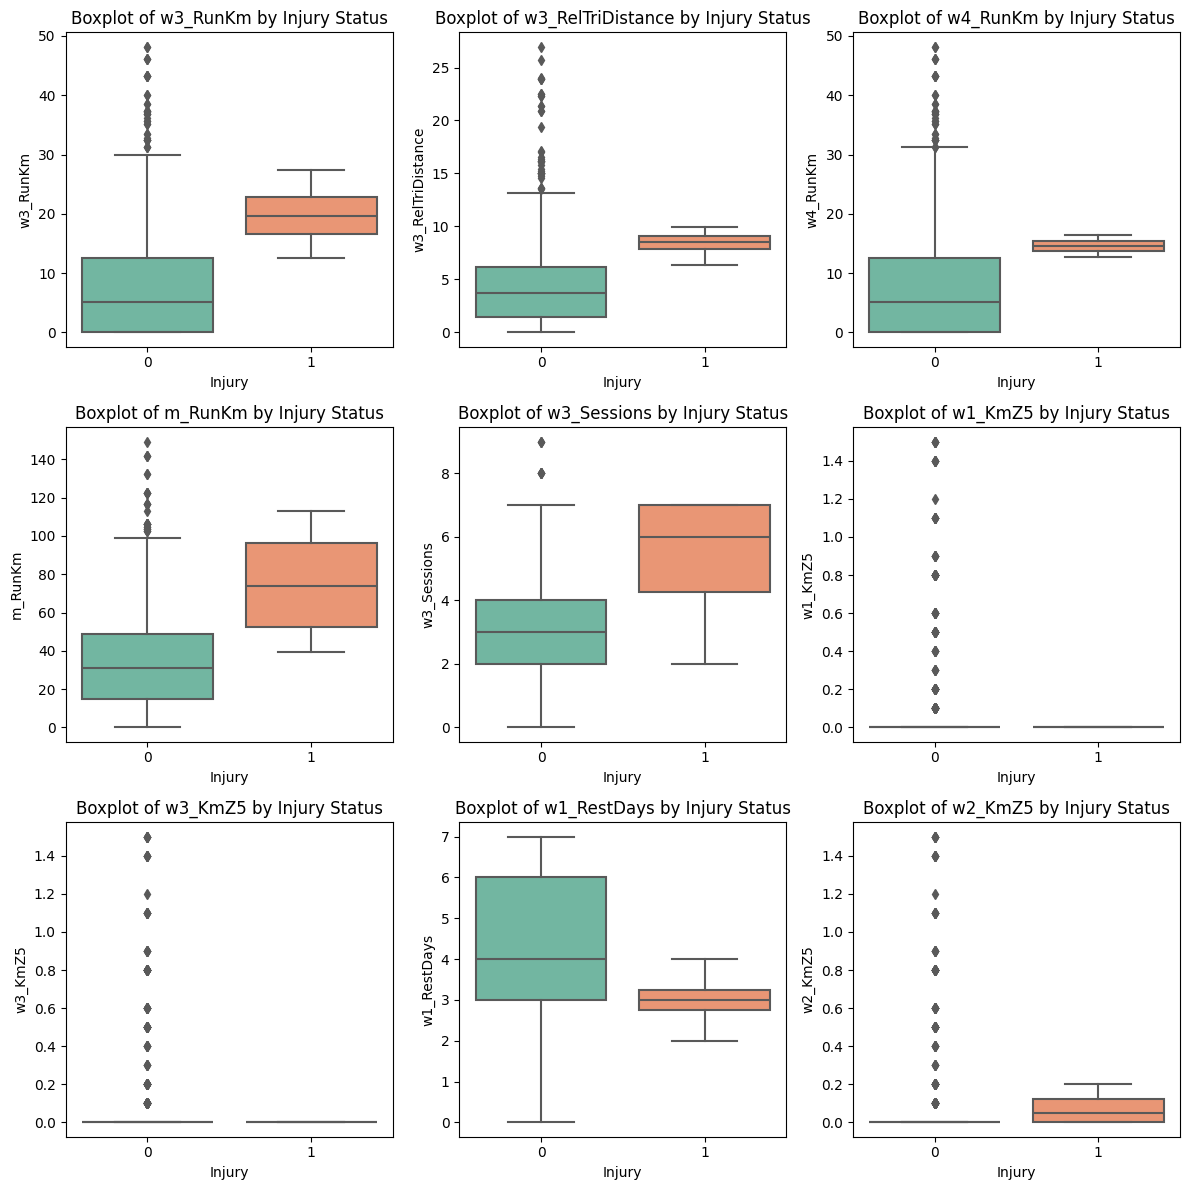

In [80]:
# Liste der Spalten, die du plotten möchtest
columns_to_plot = [
    'w3_RunKm', 
    'w3_RelTriDistance',
    'w4_RunKm',
    'm_RunKm',
    'w3_Sessions',
    'w1_KmZ5',
    'w3_KmZ5',
    'w1_RestDays',
    'w2_KmZ5',
]


# Plot erstellen
plt.figure(figsize=(12, 12))

# Iteriere über jede Spalte, um sie nach 'Injury' (0 und 1) zu plotten
for i, column in enumerate(columns_to_plot, start=1):
    plt.subplot(3, 3, i)  # Erstelle mehrere Subplots (2 Reihen und 3 Spalten)

    # Boxplot für die jeweilige Spalte und den Injury-Status
    sns.boxplot(x='Injury', y=column, data=df_final, palette='Set2')

    # Titel für jedes Subplot
    plt.title(f'Boxplot of {column} by Injury Status')

# Layout optimieren
plt.tight_layout()

# Diagramm anzeigen
plt.show()

# 3. result

After testing with several procedures we will reject the Null-Hypothesis of a significant difference before injury for the following feaures:
- w3_RunKm (✅ all)
- w3_RelTriDistance (✅ all )
- w4_RunKm (✅ T-Test, Mann-Whitney U-Test)
- m_RunKm (✅ Mann-Whitney U-Test, Permutation Test)
- w3_Sessions (✅ Mann-Whitney U-Test, Permutation Test)
- w1_RestDays (✅ T-Test)


# export new df_final to azure

In [ ]:

# df_final.to_sql('df_activs_inj_train', con=engine, schema='public', if_exists='replace', index=False, chunksize=1000, method='multi')

2309